In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU, Dropout
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, GlobalMaxPool1D

plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
train = pd.read_csv('Toxic_Multi/train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train.drop(columns = ['id'], axis = 1, inplace = True)

In [4]:
train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train[train['comment_text'] == ' ']

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [6]:
X =  train['comment_text']
y =  train.drop(['comment_text'],axis = 1)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [8]:
# using keras tokenizer

max_len = 1500
token = text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test))

X_train_seq = token.texts_to_sequences(X_train)
X_test_seq = token.texts_to_sequences(X_test)

#zero pad the sequences
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=max_len)

word_index = token.word_index

## RNN

In [9]:
model_rnn = Sequential()
model_rnn.add(Embedding(len(word_index) + 1, 300, input_length = max_len))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(6, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1500, 300)         63101400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 63,142,106
Trainable params: 63,142,106
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_history = model_rnn.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs=2, batch_size = 128)

Epoch 1/2
873/873 [==============================] - 2315s 3s/step - loss: 0.1077 - accuracy: 0.9697 - val_loss: 0.1030 - val_accuracy: 0.9294
Epoch 2/2
873/873 [==============================] - 2399s 3s/step - loss: 0.0711 - accuracy: 0.9631 - val_loss: 0.0683 - val_accuracy: 0.9938


In [11]:
rnn_loss, rnn_acc = model_rnn.evaluate(X_test_pad, y_test)
print(f"Loss :- {rnn_loss}, Accuracy :- {rnn_acc}")

1496/1496 [==============================] - 586s 392ms/step - loss: 0.0683 - accuracy: 0.9938
Loss :- 0.06829474866390228, Accuracy :- 0.9937541484832764


In [17]:
rnn_preds = model_rnn.predict(X_test_pad)

1496/1496 [==============================] - 501s 335ms/step


In [18]:
y_test.head(20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0
79050,0,0,0,0,0,0
86098,0,0,0,0,0,0
55703,0,0,0,0,0,0
113939,0,0,0,0,0,0
19481,0,0,0,0,0,0


In [19]:
rnn_preds = pd.DataFrame(rnn_preds)
rnn_preds.head(20)

,0,1,2,3,4,5
0,0.013884,0.000269,0.003415,0.000226,0.004138,0.000639
1,0.041192,0.001095,0.008067,0.001419,0.010734,0.002986
2,0.012317,0.000945,0.003877,0.001200,0.004409,0.002227
3,0.009827,0.000538,0.003563,0.000686,0.003872,0.001553
4,0.037726,0.000572,0.006785,0.000557,0.008416,0.001656
5,0.014035,0.000261,0.003906,0.000281,0.004820,0.000796
6,0.028163,0.000721,0.007021,0.000694,0.007676,0.001700
7,0.013011,0.000698,0.004079,0.000850,0.004068,0.001715
8,0.016360,0.000630,0.004849,0.000656,0.005117,0.001678
9,0.024173,0.000593,0.006651,0.000586,0.007069,0.002116


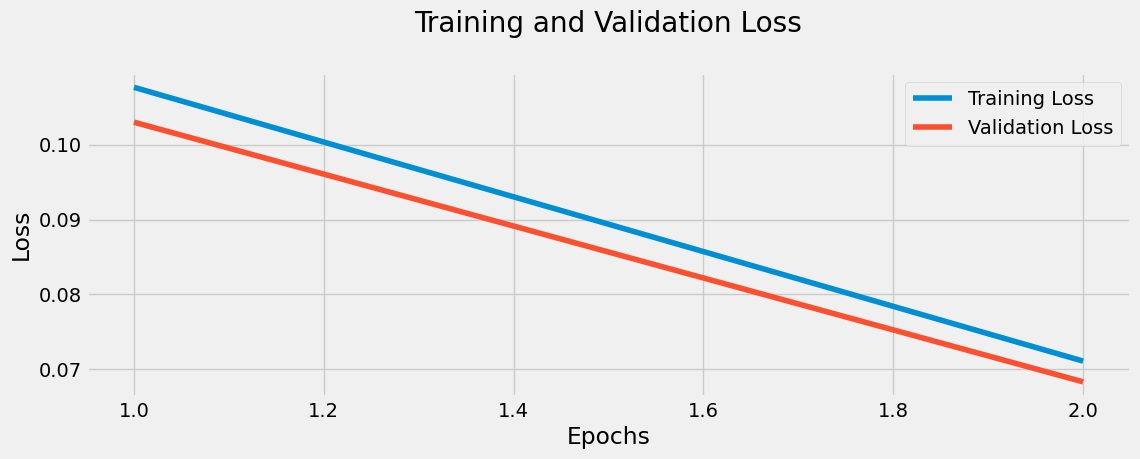

In [20]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 3)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

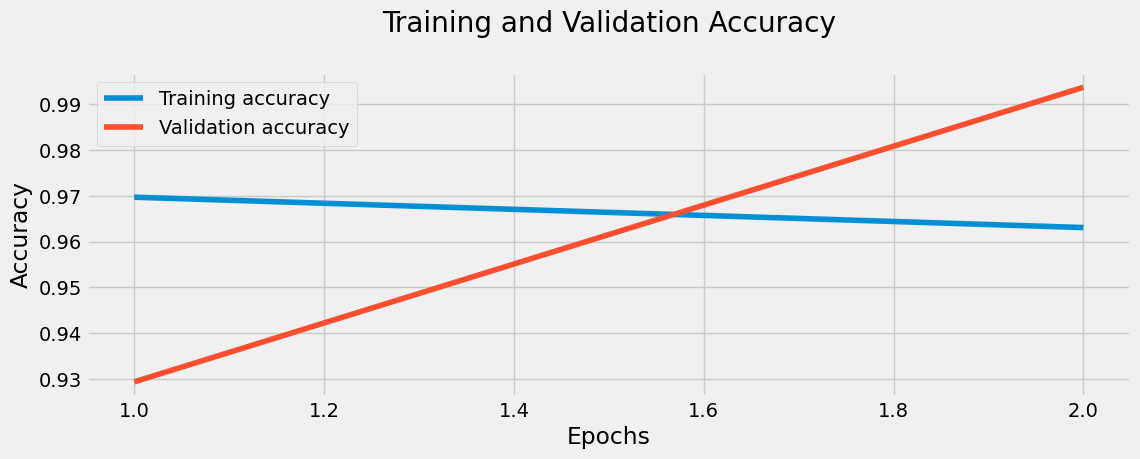

In [21]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 3)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### LSTM

In [17]:
model_lstm = Sequential()
model_lstm.add(Embedding(len(word_index) + 1, 128 , input_length = max_len))
model_lstm.add(CuDNNLSTM(60,  return_sequences=True))
model_lstm.add(GlobalMaxPool1D())
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(50, activation = 'relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(6, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
print(model_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 128)         26923264  
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 1500, 60)          45600     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                      

In [18]:
model_history = model_lstm.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test),epochs = 3, batch_size = 64)

Epoch 1/3
1746/1746 [==============================] - 227s 129ms/step - loss: 0.1017 - accuracy: 0.9116 - val_loss: 0.0493 - val_accuracy: 0.9938
Epoch 2/3
1746/1746 [==============================] - 214s 123ms/step - loss: 0.0458 - accuracy: 0.9915 - val_loss: 0.0462 - val_accuracy: 0.9938
Epoch 3/3
1746/1746 [==============================] - 223s 127ms/step - loss: 0.0368 - accuracy: 0.9926 - val_loss: 0.0481 - val_accuracy: 0.9931


In [19]:
lstm_loss, lstm_acc = model_lstm.evaluate(X_test_pad, y_test)

1496/1496 [==============================] - 33s 22ms/step - loss: 0.0481 - accuracy: 0.9931


In [20]:
lstm_preds = model_lstm.predict(X_test_pad)

1496/1496 [==============================] - 29s 19ms/step


In [21]:
y_test.head(20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0
79050,0,0,0,0,0,0
86098,0,0,0,0,0,0
55703,0,0,0,0,0,0
113939,0,0,0,0,0,0
19481,0,0,0,0,0,0


In [22]:
lstm_preds = pd.DataFrame(lstm_preds)
lstm_preds.head(20)

,0,1,2,3,4,5
0,0.012623,1.781660e-05,0.000637,0.000310,0.001380,3.163398e-04
1,0.826421,1.184749e-02,0.139985,0.049830,0.320019,9.020734e-02
2,0.564255,1.772190e-03,0.042660,0.011337,0.168561,3.694844e-02
3,0.000903,9.984760e-07,0.000044,0.000055,0.000056,1.682952e-05
4,0.000305,1.544360e-07,0.000016,0.000007,0.000019,3.441635e-06
5,0.000161,1.048097e-07,0.000010,0.000006,0.000008,1.774358e-06
6,0.002712,1.096895e-06,0.000082,0.000089,0.000146,3.608473e-05
7,0.000249,1.604288e-07,0.000014,0.000009,0.000014,3.061187e-06
8,0.010156,7.994897e-06,0.000335,0.000813,0.000440,1.659663e-04
9,0.002112,1.699517e-06,0.000133,0.000086,0.000135,3.527122e-05


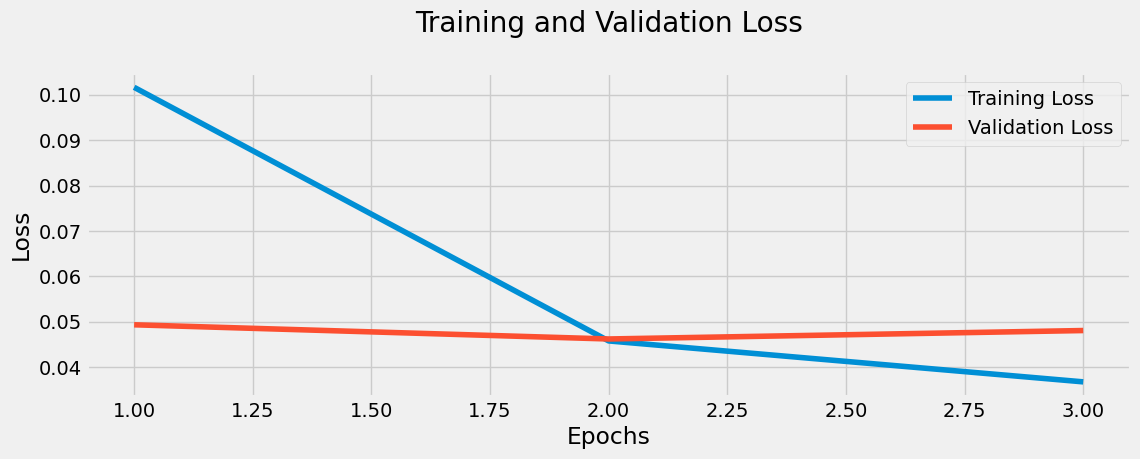

In [23]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 4)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

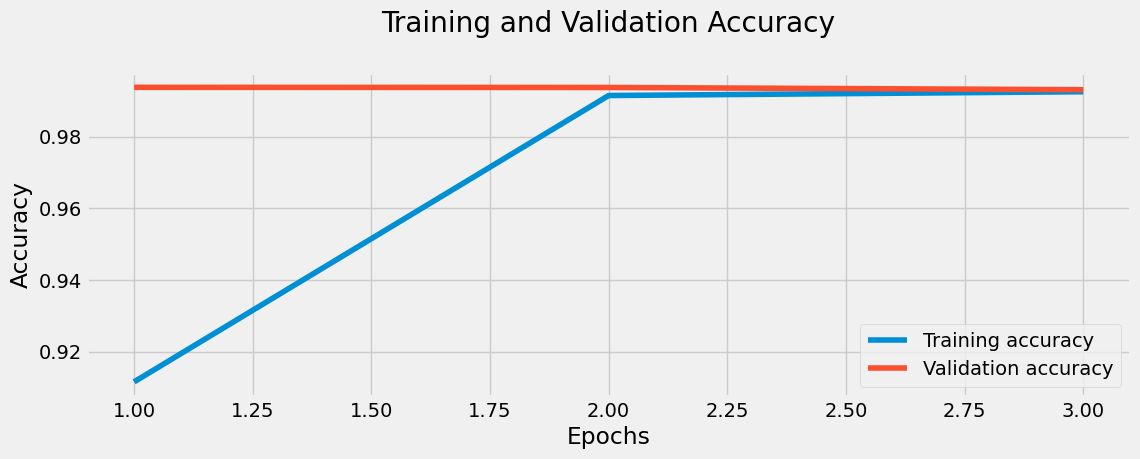

In [24]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 4)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### GRU

In [26]:
## Creating model

model_gru=Sequential()
model_gru.add(Embedding(len(word_index) + 1, 300 , input_length=max_len))
model_gru.add(GlobalMaxPool1D())
model_gru.add(Dropout(0.1))
model_gru.add(Dense(50, activation = 'relu'))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(6, activation='sigmoid'))
model_gru.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
print(model_gru.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1500, 300)         63101400  
                                                                 
 global_max_pooling1d_4 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                15050     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 306       
                                                      

In [27]:
model_history = model_gru.fit(X_train_pad, y_train, validation_data = (X_test_pad, y_test), epochs=3, batch_size = 64)

Epoch 1/3
1746/1746 [==============================] - 130s 74ms/step - loss: 0.0850 - accuracy: 0.8676 - val_loss: 0.0520 - val_accuracy: 0.9938
Epoch 2/3
1746/1746 [==============================] - 155s 89ms/step - loss: 0.0467 - accuracy: 0.9812 - val_loss: 0.0483 - val_accuracy: 0.9938
Epoch 3/3
1746/1746 [==============================] - 108s 62ms/step - loss: 0.0389 - accuracy: 0.9749 - val_loss: 0.0481 - val_accuracy: 0.9913


In [28]:
gru_loss, gru_acc = model_gru.evaluate(X_test_pad, y_test)

1496/1496 [==============================] - 5s 3ms/step - loss: 0.0481 - accuracy: 0.9913


In [29]:
gru_preds = model_gru.predict(X_test_pad)

1496/1496 [==============================] - 3s 2ms/step


In [30]:
y_test.head(20)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
74251,0,0,0,0,0,0
131406,1,0,0,0,0,0
120969,0,0,0,0,1,0
121827,0,0,0,0,0,0
4771,0,0,0,0,0,0
79050,0,0,0,0,0,0
86098,0,0,0,0,0,0
55703,0,0,0,0,0,0
113939,0,0,0,0,0,0
19481,0,0,0,0,0,0


In [31]:
gru_preds = pd.DataFrame(gru_preds)
gru_preds.head(20)

,0,1,2,3,4,5
0,0.000469,4.941148e-07,3.582479e-05,0.000036,0.000068,0.000036
1,0.299898,4.601624e-04,9.832948e-03,0.002450,0.013590,0.002719
2,0.558247,1.578953e-03,1.045160e-01,0.007253,0.217744,0.017573
3,0.003772,5.087675e-06,2.176538e-04,0.000196,0.000559,0.000256
4,0.000802,1.113450e-06,8.488361e-05,0.000047,0.000233,0.000073
5,0.000122,5.073412e-08,6.817718e-06,0.000005,0.000022,0.000007
6,0.000892,1.335364e-06,5.122902e-05,0.000069,0.000110,0.000048
7,0.000014,1.199585e-08,7.822314e-07,0.000002,0.000003,0.000002
8,0.000586,9.779758e-07,1.708955e-05,0.000058,0.000055,0.000024
9,0.000303,1.197235e-07,1.237238e-05,0.000014,0.000038,0.000013


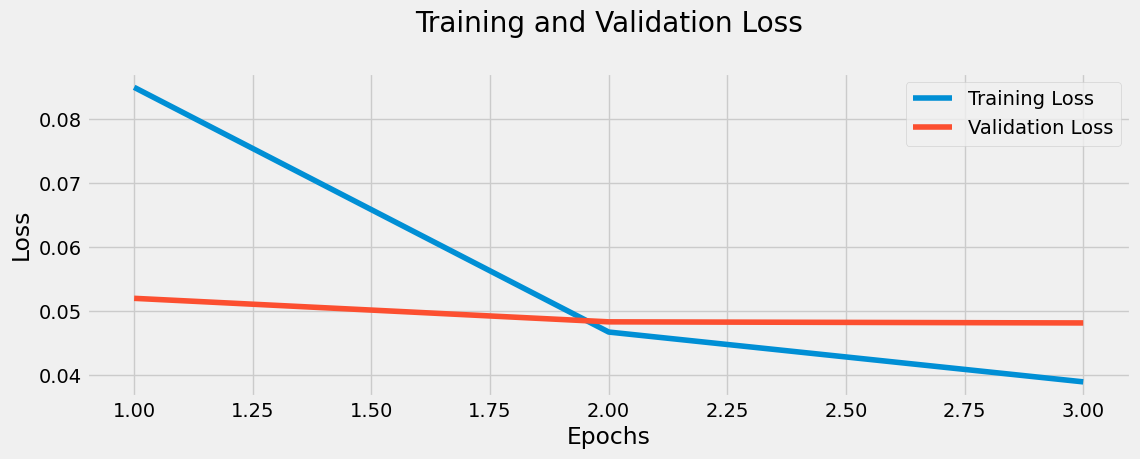

In [32]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss'] 
epoch = range(1, 4)
plt.plot(kind = 'line')
sns.lineplot(x = epoch, y = train_loss, label = 'Training Loss')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss\n')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

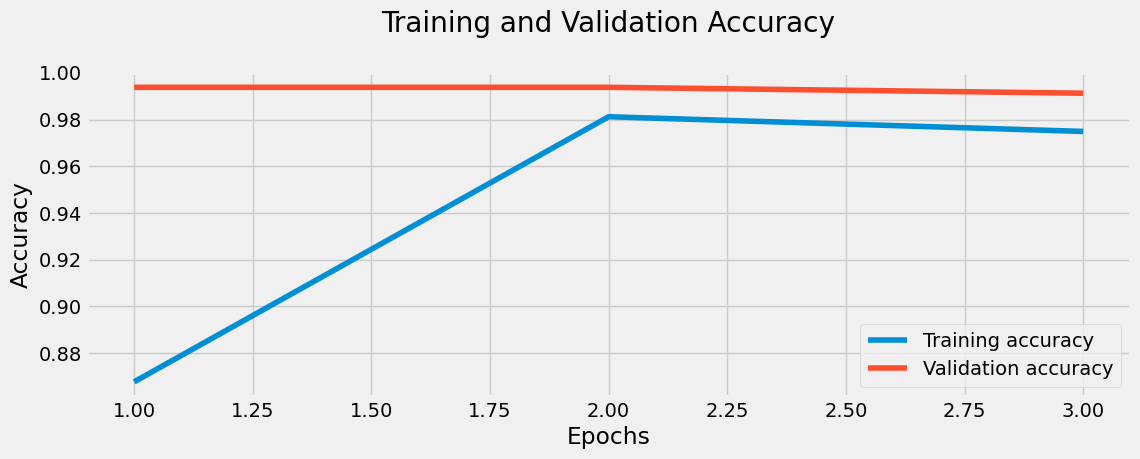

In [33]:
plt.figure(figsize = (12, 4))

train_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy'] 
epoch = range(1, 4)
sns.lineplot(x = epoch, y = train_loss, label = 'Training accuracy')
sns.lineplot(x = epoch, y = val_loss, label = 'Validation accuracy')
plt.title('Training and Validation Accuracy\n')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()